# Epidemic Model 

        In this lab, we use optimal control techniques to find a vaccination schedule for an epidemic disease. 
        Our goal is to minimize the number of infectious persons and the overall cost of the vaccine during a fixed time period.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Modelo Escolhido (SEIR)

        Our model considers three compartiments that represent three groups over the population, each one is considered homogeneous. Let $S(t), R(t)$ and $I(t)$ be the groups representing susceptible, recovered (immune) and infectious (note the difference from infecteds).
        The SEIR Model allows a incubation period foir the disease, and the infected person remains latent for some time before becoming infectious. Let $E(t)$ be this number. $N(t) = S(t) + R(t) + I(t) + E(t)$. 
        Let $u(t)$ be the control that represents the percentage of susceptible individuals being vaccinated per unit of time. $0 \leq u(t) \leq 0.9$. $b$ is the natural exponential birth rate and $d$ natural death. The incidence pf the disease is $cS(t)I(t)$ and $e$ is the tate at which the exposed infividual become infectious. And $g$ the recover rate. 

$$ min_u \int_0^T AI(t) + u(t)^2 dt \iff max_u \int_0^T - AI(t) - u(t)^2 dt $$ 

$$ s.a ~~ S'(t) = bN(t) - dS(t) - cS(t)I(t) - u(t)S(t), S(0) = S_0 \geq 0 $$

$$ E'(t) = cS(t)I(t) - (e + d)E(t), E(0) = E_0 \geq 0 $$

$$I'(t) = eE(t) - (g + a + d)I(t), I(0) = I_0 \geq 0$$

$$R'(t) = gI(t) - dR(t) + u(t)S(t), R(0) = R_0 \geq 0$$

$$N'(t) = (b - d)N(t) - aI(t), N(0) = N_0$$

$$0\leq u(t) \leq 0.9$$

## Functions

In [2]:
f = lambda A,I,u: - A*I - u**2
g_S = lambda b,c,d,S,E,I,R,u: b*(S + E + I + R) - d*S - c*S*I - u*S
g_E = lambda c,e,d,S,E,I,R,u: c*S*I - (e + d)*E
g_I = lambda a,d,e,g,S,E,I,R,u: e*E - (g + a + d)*I
g_R = lambda d,g,S,E,I,R,u: g*I - d*R + u*S 

Sejam $\lambda_1(t),\lambda_2(t),\lambda_3(t),\lambda_4(t)$ funções deriváveis por partes
   
$\frac{\partial H}{\partial S} = \lambda_1(b - d - cI - u) + \lambda_2(cI) + \lambda_4(u) = - \lambda_1'(t)$

$\frac{\partial H}{\partial E} = \lambda_1(b) - \lambda_2(e + d) + \lambda_3(e) = - \lambda_2'(t)$

$\frac{\partial H}{\partial I} = - A + \lambda_1(b - cS) + \lambda_2(cS) - \lambda_3(g + a + d) + \lambda_4(g) = - \lambda_3'(t)$

$\frac{\partial H}{\partial R} = \lambda_1(b) - \lambda_4(d) = - \lambda_4'(t)$

Note que $\lambda_1(T) = \lambda_2(T) = \lambda_3(T) = \lambda_4(T) = 0 $

$\frac{\partial H}{\partial u} = -2u - \lambda_1(S) + \lambda_4(S)$

$\frac{\partial H}{\partial u} < 0 \Rightarrow u(t) = 0 \Rightarrow -2u - \lambda_1(S) + \lambda_4(S) < 0 \Rightarrow S(\lambda_4 - \lambda_1) < 0 \Rightarrow \frac{1}{2}S(\lambda_4 - \lambda_1) < 0 $

$\frac{\partial H}{\partial u} > 0 \Rightarrow u(t) = 0.9 \Rightarrow -2u - \lambda_1(S) + \lambda_4(S) > 0 \Rightarrow S(\lambda_4 - \lambda_1) > 1.8 \Rightarrow \frac{1}{2}S(\lambda_4 - \lambda_1) > 0.9$

$\frac{\partial H}{\partial u} = 0 \Rightarrow 0 \leq u(t) \leq 0.9 \Rightarrow -2u - \lambda_1(S) + \lambda_4(S) = 0 \Rightarrow u(t) = \frac{1}{2}S(\lambda_4 - \lambda_1) \Rightarrow 0 \leq \frac{1}{2}S(\lambda_4 - \lambda_1) \leq 0.9$

Portanto $u^*(t) = \max(0, \min(\frac{1}{2}S(\lambda_4 - \lambda_1),0.9)) $

In [2]:
class Epidemic:
    
    def __init__(self,A,a,b,c,d,e,g,T,S0,E0,I0,R0):
        
        self.A = A
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
        self.g = g
        self.T = T
        self.S0 = S0
        self.E0 = E0
        self.I0 = I0
        self.R0 = R0
        
        self.Fg = {"S": lambda S,E,I,R,u: self.b*(S + E + I + R) - self.d*S - self.c*S*I - u*S, 
                  "E": lambda S,E,I,R,u: self.c*S*I - (self.e + self.d)*E,
                  "I": lambda S,E,I,R,u: self.e*E - (self.g + self.a + self.d)*I,
                  "R": lambda S,E,I,R,u: self.g*I - self.d*R + u*S}
        
        self.dadj = {"A1":lambda S,E,I,R,u,lam,adj,i: -lam*(self.b - self.d - self.c*I - u) 
                                                - adj[1][i]*self.c*I - adj[3][i]*u,
                     "A2":lambda S,E,I,R,u,lam,adj,i: -adj[0][i]*self.b + lam*(self.e + self.d) - adj[2][i]*self.e, 
                     "A3":lambda S,E,I,R,u,lam,adj,i: self.A - adj[0][i]*(self.b - self.c*S) - adj[1][i]*self.c*S + 
                                                adj[2][i]*(self.g + self.a + self.d) - lam*self.g,
                     "A4": lambda S,E,I,R,u,lam,adj,i: -adj[0][i]*b + adj[3][i]*d}
        
    Fu = lambda self,S,E,I,R,u,adj,i: max(0,min(1/2*S*(adj[3][i] - adj[0][i]),0.9))
    
    def runge_kutta_state(self,S,E,I,R,u,adj,N,h):
        
        for i in range(N):
                
            k11 = self.Fg['S'](S[i],E[i],I[i],R[i],u[i])
            k12 = self.Fg['E'](S[i],E[i],I[i],R[i],u[i])
            k13 = self.Fg['I'](S[i],E[i],I[i],R[i],u[i])
            k14 = self.Fg['R'](S[i],E[i],I[i],R[i],u[i])

            k21 = self.Fg["S"](S[i]+h*k11/2,E[i],I[i],R[i],u[i])
            k22 = self.Fg["E"](S[i],E[i]+h*k12/2,I[i],R[i],u[i])
            k23 = self.Fg["I"](S[i],E[i],I[i]+h*k13/2,R[i],u[i])
            k24 = self.Fg["R"](S[i],E[i],I[i],R[i]+h*k14/2,u[i])

            k31 = self.Fg["S"](S[i]+h*k21/2,E[i],I[i],R[i],u[i])
            k32 = self.Fg["E"](S[i],E[i]+h*k22/2,I[i],R[i],u[i])
            k33 = self.Fg["I"](S[i],E[i],I[i]+h*k23/2,R[i],u[i])
            k34 = self.Fg["R"](S[i],E[i],I[i],R[i]+h*k24/2,u[i])

            k41 = self.Fg["S"](S[i]+h*k31,E[i],I[i],R[i],u[i])
            k42 = self.Fg["E"](S[i],E[i]+h*k32,I[i],R[i],u[i])
            k43 = self.Fg["I"](S[i],E[i],I[i]+h*k33,R[i],u[i])
            k44 = self.Fg["R"](S[i],E[i],I[i],R[i]+h*k34,u[i])

            S[i+1] = S[i] + (h/6)*(k11 + 2*k21 + 2*k31 + k41)
            E[i+1] = E[i] + (h/6)*(k12 + 2*k22 + 2*k32 + k42)
            I[i+1] = I[i] + (h/6)*(k13 + 2*k23 + 2*k33 + k43)
            R[i+1] = R[i] + (h/6)*(k14 + 2*k24 + 2*k34 + k44)

        return S,E,I,R

    def runge_kutta_adj(self,S,E,I,R,u,adj,N,h):
    
        for i in range(N,0,-1):
            
            k11 = self.dadj["A1"](S[i],E[i],I[i],R[i],u[i],adj[0][i],adj,i)
            k12 = self.dadj["A2"](S[i],E[i],I[i],R[i],u[i],adj[1][i],adj,i)
            k13 = self.dadj["A3"](S[i],E[i],I[i],R[i],u[i],adj[2][i],adj,i)
            k14 = self.dadj["A4"](S[i],E[i],I[i],R[i],u[i],adj[3][i],adj,i)

            k21 = self.dadj["A1"](S[i],E[i],I[i],R[i],u[i],adj[0][i]+h*k11/2,adj,i)
            k22 = self.dadj["A2"](S[i],E[i],I[i],R[i],u[i],adj[1][i]+h*k12/2,adj,i)
            k23 = self.dadj["A3"](S[i],E[i],I[i],R[i],u[i],adj[2][i]+h*k13/2,adj,i)
            k24 = self.dadj["A4"](S[i],E[i],I[i],R[i],u[i],adj[3][i]+h*k14/2,adj,i)

            k31 = self.dadj["A1"](S[i],E[i],I[i],R[i],u[i],adj[0][i]+h*k21/2,adj,i)
            k32 = self.dadj["A2"](S[i],E[i],I[i],R[i],u[i],adj[1][i]+h*k22/2,adj,i)
            k33 = self.dadj["A3"](S[i],E[i],I[i],R[i],u[i],adj[2][i]+h*k23/2,adj,i)
            k34 = self.dadj["A4"](S[i],E[i],I[i],R[i],u[i],adj[3][i]+h*k24/2,adj,i)

            k41 = self.dadj["A1"](S[i],E[i],I[i],R[i],u[i],adj[0][i]+h*k31,adj,i)
            k42 = self.dadj["A2"](S[i],E[i],I[i],R[i],u[i],adj[1][i]+h*k32,adj,i)
            k43 = self.dadj["A3"](S[i],E[i],I[i],R[i],u[i],adj[2][i]+h*k33,adj,i)
            k44 = self.dadj["A4"](S[i],E[i],I[i],R[i],u[i],adj[3][i]+h*k34,adj,i)
            
            adj[0][i-1] = adj[0][i] - (h/6)*(k11 + 2*k21 + 2*k31 + k41)
            adj[1][i-1] = adj[1][i] - (h/6)*(k12 + 2*k22 + 2*k32 + k42)
            adj[2][i-1] = adj[2][i] - (h/6)*(k13 + 2*k23 + 2*k33 + k43)
            adj[3][i-1] = adj[3][i] - (h/6)*(k14 + 2*k24 + 2*k34 + k44)
        
        return adj
    
    def solve(self):
        #parameters
        N = 100
        h = 1/N
        p = 0.001
        test = -1
        
        #variables
        S = np.zeros(N + 1)
        E = np.zeros(N + 1)
        I = np.zeros(N + 1)
        R = np.zeros(N + 1)
        
        adj = [np.zeros(N + 1) for i in range(4)]
        
        u = np.zeros(N + 1)
        
        S[0],E[0],I[0],R[0] = self.S0,self.E0,self.I0,self.R0
        
        adj[0][-1],adj[1][-1],adj[2][-1],adj[3][-1] = 0,0,0,0

        while test < 0:
        
            old_u = u.copy()
            
            old_S = S.copy()
            old_E = E.copy()
            old_I = I.copy()
            old_R = R.copy()

            old_adj = adj.copy()
            
            S,E,I,R = self.runge_kutta_state(old_S,old_E,old_I,old_R,u,old_adj,N,h)

            adj = self.runge_kutta_adj(S,E,I,R,u,old_adj,N,h)
            
            for i in range(len(u)): 
                u[i] = 0.5*(self.Fu(S[i],E[i],I[i],R[i],u[i],adj,i) + old_u[i])

            temp1 = p*sum(abs(u)) - sum(abs(old_u - u))
            
            temp2 = p*sum(abs(S)) - sum(abs(old_S - S))
            temp3 = p*sum(abs(E)) - sum(abs(old_E - E))
            temp4 = p*sum(abs(I)) - sum(abs(old_I - I))
            temp5 = p*sum(abs(R)) - sum(abs(old_R - R))
        
            temp6 = p*sum(abs(adj[0])) - sum(abs(old_adj[0] - adj[0]))
            temp7 = p*sum(abs(adj[1])) - sum(abs(old_adj[1] - adj[1]))
            temp8 = p*sum(abs(adj[2])) - sum(abs(old_adj[2] - adj[2]))
            temp9 = p*sum(abs(adj[3])) - sum(abs(old_adj[3] - adj[3]))
            
            test = min(temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9)
        
        return S,E,I,R,u

## Testing with some parameters

In [3]:
A,a,b,c,d,e,g,T,S0,E0,I0,R0 = 0.1,0.2,0.525,0.001,0.5,0.5,0.1,20,1000,100,50,15

In [5]:
problem = Epidemic(A,a,b,c,d,e,g,T,S0,E0,I0,R0)
S,E,I,R,u = problem.solve()

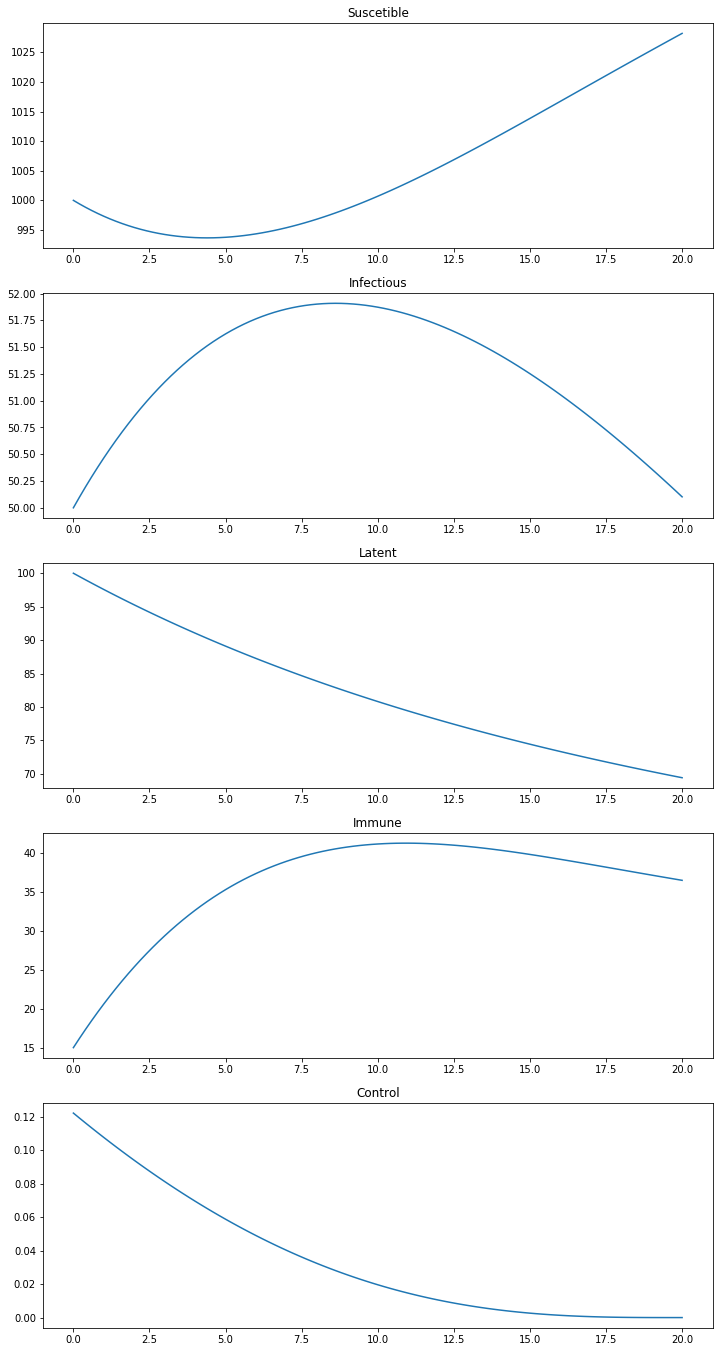

In [6]:
t = np.linspace(0,T,100 + 1)

fig = plt.figure(figsize=(12,24))
plt.subplot(5,1,1)
plt.plot(t, S)
plt.title('Suscetible')
plt.subplot(5,1,2)
plt.plot(t, I)
plt.title('Infectious')
plt.subplot(5,1,3)
plt.plot(t, E)
plt.title('Latent')
plt.subplot(5,1,4)
plt.plot(t, R)
plt.title('Immune')
plt.subplot(5,1,5)
plt.plot(t, u)
plt.title('Control')
plt.show()